In [25]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from libs.TrafficGenerator import DatasetConvertor 
from libs.TrafficPredictor.ContextAssisted import PreparingDataset as PreparingDatasetCA
from libs.TrafficPredictor.ContextAssisted import trainModelByDefaultSetting as trainModelCA
from libs.TrafficPredictor.ContextAssisted import evaluateModel as evaluateModelCA
from libs.TrafficPredictor.ContextAssisted import createModel as createModelCA
from libs import encode_float_filename, decode_float_filename

In [26]:
dbParams = 0.01
direction = "forward"
#dbParams = 0.2
#direction = "backward"
#mode = "adaptive"
mode = "fixed"
lenWindow = 10

dbpString = encode_float_filename(dbParams)
'''
with open(f"Results/TrafficPredictor/modelData/{direction}_{lenWindow}_{mode}_{dbpString}.pkl", "rb") as file:
    modelData = pickle.load(file)
with open(f"Results/TrafficPredictor/modelParams/{direction}_{lenWindow}_{mode}_{dbpString}.pkl", "rb") as file:
    modleParametersCA = pickle.load(file)
trafficModelCA, _ = createModelCA(modleParametersCA)
trafficModelCA.load_state_dict(torch.load(f"Results/TrafficPredictor/model/{direction}_{lenWindow}_{mode}_{dbpString}.pth"))
trafficModelCA.eval()  # if you're evaluating/inferencing
'''
with open(f"Results/TrafficPredictor/evaluate/CA/{direction}_{lenWindow}_{mode}_{dbpString}_train.pkl", "rb") as file:
    resultsTrain = pickle.load(file)
with open(f"Results/TrafficPredictor/evaluate/CA/{direction}_{lenWindow}_{mode}_{dbpString}_test.pkl", "rb") as file:
    resultsTest = pickle.load(file)

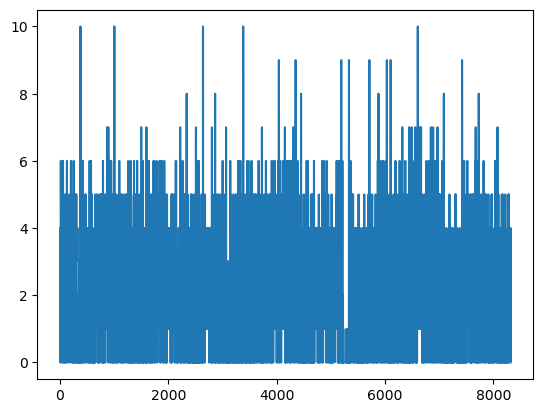

In [27]:
plt.plot(resultsTrain['classDistribu_actual'])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[1103. 1839. 1688. 1770. 1355.  401.  124.   22.    8.    8.    5.]]


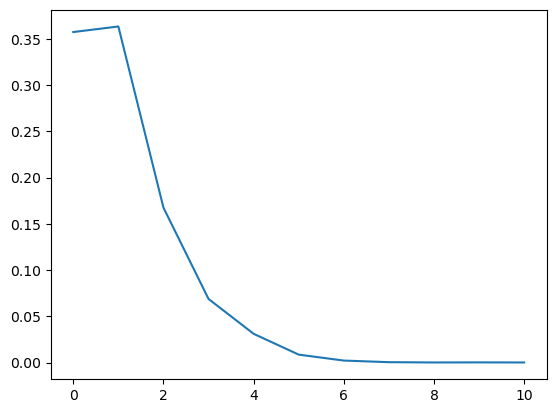

In [28]:
def softmax(x):
    e_x = np.exp(x - np.max(x))  # for numerical stability
    return e_x / np.sum(e_x)

def compute_context_aware_transition_matrix(resultsTrain, lenWindow, alpha=1e-20):
    classDistribu_predicted = resultsTrain["classDistribu_predicted"]
    trafficSource = resultsTrain["trafficSource_actual"]

    P = np.zeros((lenWindow + 1, lenWindow + 1))
    traffic_count = np.zeros((lenWindow + 1, 1))

    for i in range(trafficSource.shape[0] - 1):
        traffic = int(trafficSource[i, 0])
        P[traffic] += softmax(classDistribu_predicted[i, :])
        traffic_count[traffic] += 1

    for i in range(lenWindow + 1):
        P[i, :] /= (traffic_count[i] + 1)

    P = P + alpha
    P = P / P.sum(axis=1, keepdims=True)

    return P, traffic_count

transMatrixContextAware, traffic_count = compute_context_aware_transition_matrix(resultsTrain, lenWindow)
print(np.sum(transMatrixContextAware, axis=1))
print(traffic_count.T)
plt.plot(transMatrixContextAware[0,:])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(11, 11)


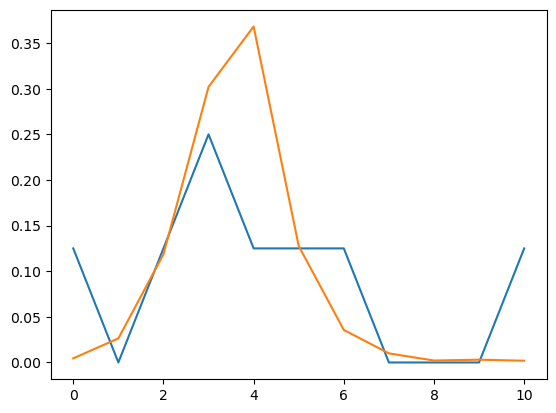

In [29]:
def compute_transition_matrix(x_t_minus_1, x_t, L, alpha=1e-20):
    x_t_minus_1 = x_t_minus_1.astype(int)
    x_t = x_t.astype(int)
    P = np.zeros((L , L ))

    for i, j in zip(x_t_minus_1, x_t):
        P[i, j] += 1

    # Normalize rows to get probabilities
    row_sums = P.sum(axis=1, keepdims=True)
    with np.errstate(divide='ignore', invalid='ignore'):
        P = np.divide(P, row_sums, where=row_sums != 0)  # avoid division by zero

    P = P + alpha
    P = P / P.sum(axis=1, keepdims=True)

    return P

trafficTarget = resultsTrain['trafficTarget_actual']
trafficSource = resultsTrain['trafficSource_actual']
transMatrixContextFree = compute_transition_matrix(trafficSource, trafficTarget, lenWindow+1, alpha=1e-20)
print(np.sum(transMatrixContextFree, axis=1))
print(np.sum(transMatrixContextAware, axis=1))

print(transMatrixContextFree.shape)
plt.plot(transMatrixContextFree[8,:])
plt.plot(transMatrixContextAware[8,:])

4
Imporvement: 0.0643952603918194
perpCF: 4.964672804910991, perpCA: 4.644971406878564
logLikeCF: -830.8395298755487, logLikeCA: -797.5422924369326


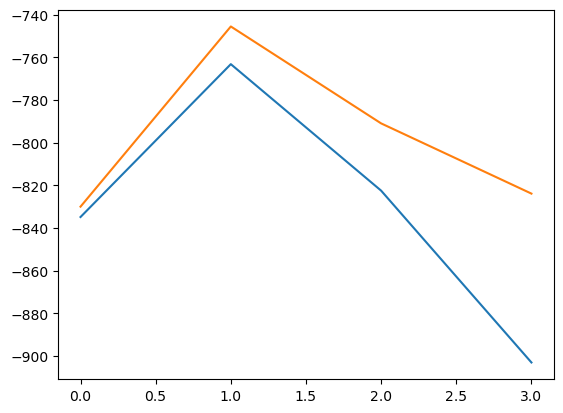

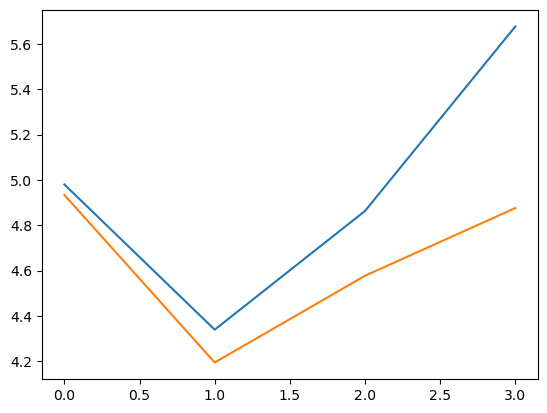

In [30]:
import numpy as np

def compute_log_likelihood_and_perplexity(M, x_test0, x_test1, N=10):
    x_test0 = x_test0.astype(int)
    x_test1 = x_test1.astype(int)

    #M_smooth = M + alpha
    #M_smooth = M_smooth / M_smooth.sum(axis=1, keepdims=True)

    transitions = list(zip(x_test0, x_test1))
    chunks = np.array_split(transitions, N)

    loglike_list = []
    perplexity_list = []

    for chunk in chunks:
        log_likelihood = 0.0
        for i, j in chunk:
            prob = max(M[i, j], 1e-20)
            log_likelihood += np.log(prob)
        perplexity = np.exp(-log_likelihood / len(chunk))

        loglike_list.append(log_likelihood)
        perplexity_list.append(perplexity)

    return loglike_list, perplexity_list

LEN_period = 500
N = np.floor(len(resultsTest['trafficSource_actual'])/LEN_period).astype(int)
print(N)
sourceTraffic = resultsTest['trafficSource_actual']
targetTraffic = resultsTest['trafficTarget_actual']
logLikeCA, perpCA = compute_log_likelihood_and_perplexity(transMatrixContextAware, sourceTraffic, targetTraffic, N=N)
logLikeCF, perpCF = compute_log_likelihood_and_perplexity(transMatrixContextFree, sourceTraffic, targetTraffic, N=N)

print(f"Imporvement: {abs(np.mean(perpCA)-np.mean(perpCF))/np.mean(perpCF)}")
print(f"perpCF: {np.mean(perpCF)}, perpCA: {np.mean(perpCA)}")
print(f"logLikeCF: {np.mean(logLikeCF)}, logLikeCA: {np.mean(logLikeCA)}")

plt.plot(logLikeCF)
plt.plot(logLikeCA)
plt.show()
plt.plot(perpCF)
plt.plot(perpCA)
plt.show()